# Importando Bibliotecas e Funções

In [3]:
#importando módulos
import functions
from functions import *

import visualization
from visualization import *


In [4]:
#aumentar display de linhas e colunas
pd.set_option('display.max_columns',350)

pd.set_option('display.min_rows',30)
pd.set_option('display.max_rows',300)

# 5. Modelagem Preditiva / Machine Learning

## 5.1 Leitura das partidas e Pré-processamento dos dados

In [23]:
#delimita as colunas a serem convertidas em json no momento da leitura do csv
JSON_COLUMNS = ['statistics', 'events', 'players', 'lineups']

#faz a leitura para as partidas
league_matches = pd.read_csv(
    'C:\\Users\\Cautela\\Desktop\\seriea_brazil.csv',
    index_col = 0,
    converters={column: literal_eval
                for column in JSON_COLUMNS})  #.drop(columns = 'Unnamed: 0')


league_matches = league_matches.sort_values(by = 'fixture.date')
#aplica a funcao transform fixture para abrir as colunas statistics, players e lineups
lm = transform_fixture(league_matches)

#dobra o tamanho dataframe das partidas, dividindo os jogos em 1 linha por time

# #time home
# league_matches1 = league_matches.copy()
# league_matches1['team.id'] = league_matches1['teams.home.id']

# #time away
# league_matches2 = league_matches.copy()
# league_matches2['team.id'] = league_matches2['teams.away.id']

# #uniao de ambos
# league_matches_c = pd.concat([league_matches1,
#                               league_matches2]).sort_values(by='fixture.date')

# #faz um merge da base de partidas com as estatisticas
# matches_complete = league_matches_c.merge(
#     lm[3], on=['fixture.id', 'team.id'],
#     how='left').merge(lm[2],
#                       on=['fixture.id', 'team.id', 'team.name'],
#                       how='left').merge(lm[1],
#                                         on=[
#                                             'fixture.id', 'team.id',
#                                             'team.name', 'team.logo'
#                                         ],
#                                         how='left')

TypeError: unhashable type: 'list'

In [ ]:
#matches_complete = matches_complete.sort_values(by = 'fixture.date')

In [ ]:
#cria a coluna target do modelo, winner 2 se casa, winner 1 se empate, winner 0 se visitante
matches_complete['winner'] = np.where(
    matches_complete['teams.home.winner'] == True, 2,
    np.where(matches_complete['teams.home.winner'] == False, 0, 1))

#remove colunas desnecessarias
matches_complete_filtered = matches_complete\
.query("`fixture.status.short`!=['TBD','NS']")\
.drop(columns=[
        'events','statistics','lineups','players',
        'fixture.referee', 'fixture.timestamp', 'fixture.timezone',
        'fixture.periods.first', 'fixture.periods.second', 'fixture.venue.id',
        'fixture.venue.city', 'fixture.venue.name', 'fixture.status.elapsed',
        'team.logo', 'league.name', 'league.country', 'league.logo','league.flag','fixture.status.short',
        'fixture.status.long', 'teams.home.winner', 'teams.away.winner',
        'teams.home.name', 'teams.away.name', 'teams.home.logo',
        'teams.away.logo', 'score.extratime.home', 'score.extratime.away',
        'score.penalty.home', 'score.penalty.away',
        'formation', 'startXI', 'substitutes', 'team.colors', 'coach.id',
        'coach.name', 'coach.photo', 'team.colors.player.primary',
        'team.colors.player.number', 'team.colors.player.border',
        'team.colors.goalkeeper.primary', 'team.colors.goalkeeper.number',
        'team.colors.goalkeeper.border'
    ])

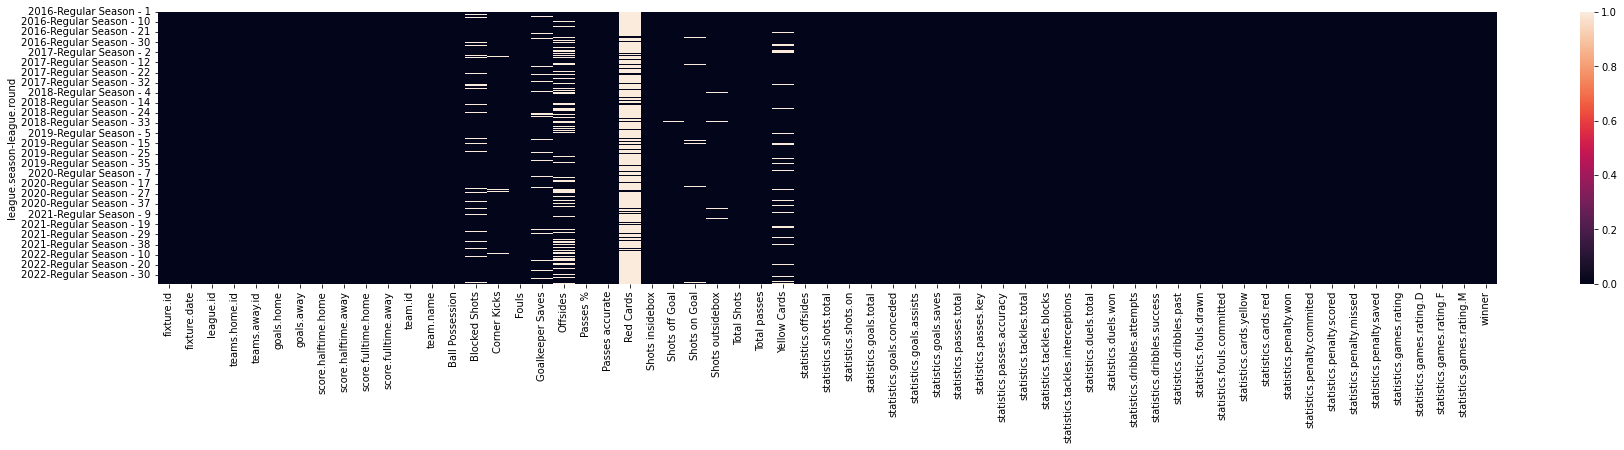

['team.name', 'Blocked Shots', 'Corner Kicks', 'Fouls', 'Goalkeeper Saves', 'Offsides', 'Red Cards', 'Shots insidebox', 'Shots off Goal', 'Shots on Goal', 'Shots outsidebox', 'Yellow Cards']


In [ ]:
#visualiza dados faltantes na base para imputacao ou exclusao
    #o que e comum? valores NaN quando as variaveis sao, na verdade, iguais a 0, como Red Cards, Offsides, Yellow Cards, etc
    #o que nao e comum? valores NaN ou 0 para colunas que deveriam ter algum valor, como Ball Possession, Passes %

fig, ax = plt.subplots(figsize = (30,5))

sns.heatmap(matches_complete_filtered.set_index(['league.season','league.round']).isnull(), ax = ax)

plt.show()

print(matches_complete_filtered.columns[matches_complete_filtered.isnull().sum() > 0].tolist())

In [ ]:
#imputa os dados das colunas derivadas de 'players', comecadas por 'statistics.'
    #substitui NaN pela media do time naquela season

players_columns = [col for col in matches_complete_filtered.columns if 'statistics' in col]

matches_complete_filtered[players_columns] = matches_complete_filtered.groupby(['team.id','league.season'])[players_columns].apply(lambda x: x.fillna(x.mean()))

In [ ]:
#imputa os dados missing pela media para todas as colunas onde BP e P% sao 0 ou nan
#pois presume-se que os dados nao sejam confiaveis

matches_complete_filtered.loc[    (matches_complete_filtered['Ball Possession'] == 0) |
    (matches_complete_filtered['Ball Possession'].isna()) |
    (matches_complete_filtered['Passes %'] == 0) |
    (matches_complete_filtered['Passes %'].isna()),
    :] = matches_complete_filtered.groupby(
        ['team.id', 'league.season']).apply(lambda x: x.fillna(x.mean()))

In [ ]:
#substitui os valores restantes por 0
matches_complete_filtered = matches_complete_filtered.fillna(0)

In [ ]:
#transforma a coluna league_round em numerica
matches_complete_filtered['league.round'] = matches_complete_filtered['league.round'].str.strip('Regular Season - ').astype(int)

#SE ERRO

#para algumas ligar europeias (coluna expected_goals)
#matches_complete_filtered = matches_complete_filtered.drop(columns = 'expected_goals')

#caso bundesliga
#matches_complete_filtered = matches_complete_filtered[~matches_complete_filtered['league.round'].isin(['Finals','Relegation Round'])]

In [ ]:
stats_columns = [
    'Ball Possession', 'Blocked Shots', 'Corner Kicks', 'Fouls',
    'Goalkeeper Saves', 'Offsides', 'Passes %', 'Passes accurate', 'Red Cards',
    'Shots insidebox', 'Shots off Goal', 'Shots on Goal', 'Shots outsidebox',
    'Total Shots', 'Total passes', 'Yellow Cards'
]

In [ ]:
#Calcula a média móvel para as variáveis desejadas
df_mm = matches_complete_filtered.groupby([
    'league.season',
    'team.id',
])[matches_complete_filtered[stats_columns + players_columns].columns].rolling(5).mean()

#Defasagem
df_mm = df_mm[df_mm.columns.difference(['league.season', 'team.id'])].groupby(
    ['league.season', 'team.id']).shift(1).reset_index()

df_mm = df_mm.rename(columns = {'level_2':'index'})

#Retorna os valores para a base original
matches_complete_filtered = matches_complete_filtered.drop(columns=[col for col in matches_complete_filtered.columns if col in stats_columns or col in players_columns], axis=1).reset_index().merge(df_mm, how = 'left')

In [ ]:
#Cria uma nova variável binária 'home', identificando se o time está jogando em casa ou fora
matches_complete_filtered.loc[matches_complete_filtered['team.id'] == matches_complete_filtered['teams.home.id'],
                  'home'] = 1
matches_complete_filtered.loc[matches_complete_filtered['team.id'] != matches_complete_filtered['teams.home.id'],
                  'home'] = 0

#Atribui a quantidade de pontos ganhos por cada time, em cada jogo
matches_complete_filtered['pontos'] = 0

matches_complete_filtered.loc[(matches_complete_filtered['winner']==2) & (matches_complete_filtered['home']==1), 'pontos'] = 3
matches_complete_filtered.loc[(matches_complete_filtered['winner']==0) & (matches_complete_filtered['home']==0), 'pontos'] = 3
matches_complete_filtered.loc[(matches_complete_filtered['winner']==1), 'pontos'] = 1

#Realiza a soma cumulativa dos pontos
df_aprov = matches_complete_filtered.groupby(['league.season','team.id'])['pontos'].cumsum()
matches_complete_filtered['pontos_acum'] = df_aprov
matches_complete_filtered = matches_complete_filtered.drop(columns = 'pontos')

#Calcula os pontos possíveis caso o time tivesse ganhado todos os jogos
matches_complete_filtered['pontos_posv'] = matches_complete_filtered['league.round']*3

#Calcula o aproveitamento
matches_complete_filtered['aproveitamento'] = matches_complete_filtered['pontos_acum'] / matches_complete_filtered['pontos_posv']

matches_complete_filtered['aproveitamento'] = matches_complete_filtered.groupby(['league.season','team.id'])['aproveitamento'].shift(1)

#Remove colunas desnecessárias
matches_complete_filtered = matches_complete_filtered.drop(columns = ['pontos_acum','pontos_posv'])

matches_complete_filtered = matches_complete_filtered.fillna(0)

In [ ]:
#Removendo as primeiras e últimas N rodadas
n = 3
matches_complete_filtered = matches_complete_filtered[(matches_complete_filtered['league.round']>n) & (matches_complete_filtered['league.round']<matches_complete_filtered['league.round'].max()-n)]

#Reordenando a base
matches_complete_filtered = matches_complete_filtered.sort_values(by = ['fixture.date','fixture.id'])

In [ ]:
matches_complete_filtered.tail()

,index,fixture.id,fixture.date,league.id,league.season,league.round,teams.home.id,teams.away.id,goals.home,goals.away,score.halftime.home,score.halftime.away,score.fulltime.home,score.fulltime.away,team.id,team.name,winner,Ball Possession,Blocked Shots,Corner Kicks,Fouls,Goalkeeper Saves,Offsides,Passes %,Passes accurate,Red Cards,Shots insidebox,Shots off Goal,Shots on Goal,Shots outsidebox,Total Shots,Total passes,Yellow Cards,statistics.cards.red,statistics.cards.yellow,statistics.dribbles.attempts,statistics.dribbles.past,statistics.dribbles.success,statistics.duels.total,statistics.duels.won,statistics.fouls.committed,statistics.fouls.drawn,statistics.games.rating,statistics.games.rating.D,statistics.games.rating.F,statistics.games.rating.M,statistics.goals.assists,statistics.goals.conceded,statistics.goals.saves,statistics.goals.total,statistics.offsides,statistics.passes.accuracy,statistics.passes.key,statistics.passes.total,statistics.penalty.commited,statistics.penalty.missed,statistics.penalty.saved,statistics.penalty.scored,statistics.penalty.won,statistics.shots.on,statistics.shots.total,statistics.tackles.blocks,statistics.tackles.interceptions,statistics.tackles.total,home,aproveitamento
5235,5235,838321,2022-10-27T22:30:00+00:00,71,2022,34,1062,152,1.0,0.0,1.0,0.0,1.0,0.0,152,Juventude,2,45.0,4.4,4.8,9.2,3.6,0.8,84.0,332.0,0.0,7.2,6.8,3.0,7.0,14.2,392.2,2.0,0.0,2.0,14.8,6.0,5.6,86.0,44.2,9.2,11.6,6.755536,6.646000,6.873333,6.782024,1.0,2.2,3.6,1.0,0.8,21.318333,11.4,392.2,0.0,0.0,0.0,0.0,0.0,3.0,9.8,2.6,12.8,13.8,0.0,0.212121
5236,5236,838329,2022-10-27T23:00:00+00:00,71,2022,34,1193,145,1.0,0.0,0.0,0.0,1.0,0.0,1193,Cuiaba,2,48.8,5.0,6.2,12.2,2.8,1.2,76.8,314.2,0.2,9.2,6.8,3.8,6.4,15.6,394.6,2.8,0.2,2.6,12.2,4.8,5.0,96.4,49.6,11.8,12.4,6.691607,6.581429,6.823333,6.739429,0.2,1.8,2.8,0.8,1.2,19.506319,8.8,376.4,0.2,0.0,0.0,0.2,0.2,3.8,10.6,2.8,7.4,11.6,1.0,0.313131
5237,5237,838329,2022-10-27T23:00:00+00:00,71,2022,34,1193,145,1.0,0.0,0.0,0.0,1.0,0.0,145,Avai,2,54.6,3.4,7.2,10.8,3.6,1.2,84.2,386.2,0.0,5.4,6.4,2.4,6.8,12.2,458.6,1.8,0.0,1.8,13.8,5.6,7.8,95.0,49.4,10.8,14.2,6.637500,6.567333,6.658000,6.672571,0.0,2.4,3.6,0.4,1.2,24.422500,8.8,458.6,0.2,0.0,0.0,0.2,0.0,2.4,8.8,2.4,9.2,14.0,0.0,0.282828
5238,5238,838308,2022-10-29T23:30:00+00:00,71,2022,32,151,131,0.0,0.0,0.0,0.0,0.0,0.0,151,Goias,1,43.4,2.4,4.4,17.6,4.2,1.8,75.6,242.6,0.0,7.2,5.0,4.8,5.0,12.2,318.0,4.0,0.0,4.0,11.4,3.6,6.0,101.0,52.4,17.6,15.2,6.861917,6.833833,6.960333,6.872286,0.8,1.8,4.2,1.4,1.8,15.638333,8.8,318.0,0.2,0.0,0.0,0.2,0.0,4.8,9.8,4.2,10.2,15.6,1.0,0.411765
5239,5239,838308,2022-10-29T23:30:00+00:00,71,2022,32,151,131,0.0,0.0,0.0,0.0,0.0,0.0,131,Corinthians,1,54.4,3.8,5.4,11.0,2.6,1.4,83.8,437.0,0.2,7.2,2.8,4.4,3.8,11.0,518.6,2.4,0.2,2.4,13.4,6.4,6.2,86.0,43.8,10.0,10.0,6.863718,6.860000,6.906667,6.883929,1.2,1.0,2.6,1.4,1.2,28.351026,8.6,498.6,0.0,0.0,0.0,0.2,0.2,4.2,6.8,4.6,8.0,16.8,0.0,0.558824


## 5.2 União com base de predictions

In [14]:
#faz a leitura para as predictions
df_pred = pd.read_csv('C:\\Users\\Cautela\\Desktop\\pred_seriea_brazil.csv')

In [15]:
#divisao das estatisticas fornecidas nas previsoes em time .home e .away

#coloca em index as variaveis comuns a ambos
df_predx = df_pred.set_index([
    'predictions.winner.id', 'predictions.winner.name',
    'predictions.winner.comment', 'predictions.win_or_draw',
    'predictions.under_over'
])

#separa as variaveis referentes ao time .away
df_preda = df_predx.filter([i for i in df_predx.columns if 'away.' in i] + [
    'fixture.id',
    'comparison.form.away',
    'comparison.att.away',
    'comparison.def.away',
    'comparison.poisson_distribution.away',
    'comparison.h2h.away',
    'comparison.goals.away',
    'comparison.total.away',
]).reset_index().rename(columns={'teams.away.id': 'team.id'})

df_preda.columns = df_preda.columns.str.replace('away.', '')

#separa as variaveis referentes ao time .home
df_predh = df_predx.filter([i for i in df_predx.columns if 'home.' in i] + [
    'fixture.id',
    'comparison.form.home',
    'comparison.att.home',
    'comparison.def.home',
    'comparison.poisson_distribution.home',
    'comparison.h2h.home',
    'comparison.goals.home',
    'comparison.total.home',
]).reset_index().rename(columns={'teams.home.id': 'team.id'})

df_predh.columns = df_predh.columns.str.replace('home.', '')

In [16]:
# Substituindo '.home' por '' apenas nas colunas que contêm a palavra 'comparison'
cols_to_replace_h = [col for col in df_predh.columns if 'comparison' in col]
cols_to_replace_a = [col for col in df_preda.columns if 'comparison' in col]
df_predh.rename(columns={col: col.replace('.home', '') for col in cols_to_replace_h}, inplace=True)
df_preda.rename(columns={col: col.replace('.away', '') for col in cols_to_replace_a}, inplace=True)

In [17]:
#concatena as informacoes de home e away novamente, de forma a termos 2 linhas, uma para cada time
df_pred2 = pd.concat([df_predh,df_preda])

In [18]:
#remove as colunas que possuem valores em percentage
#remove as colunas que possuem valores discretos (comparison e biggest)
#TESTE - remove tambem as colunas de comparison

df_pred2 = df_pred2.drop(columns=[
    col for col in df_pred2.columns if '.percentage' in col
    or 'comparison' in col or 'biggest' in col or 'predictions' in col
])

In [19]:
#remove colunas nao numericas

df_pred2 = df_pred2.drop(columns=[
    'teams.last_5.form', 'teams.last_5.att', 'teams.last_5.def',
    'teams.league.form', 'teams.league.fixtures.played.home',
    'teams.league.fixtures.played.away', 'teams.league.fixtures.played.total',
    'teams.league.lineups','teams.name','teams.logo'
])

#transforma NaNs em 0
df_pred2 = df_pred2.fillna(0)

In [20]:
#concatena as informacoes com os dados de confrontos

matches_cmp_filt_pred = matches_complete_filtered.merge(df_pred2, on = ['fixture.id','team.id'], how = 'left')

matches_cmp_filt_pred.tail(6)

NameError: name 'matches_complete_filtered' is not defined

In [21]:
#Move as variáveis imutáveis para o índice
matches_cmp_filt_pred = matches_cmp_filt_pred.set_index([
    'fixture.id', 'fixture.date', 'league.round', 'league.season', 'teams.home.id'
    , 'teams.away.id', 'winner','league.id'
]).drop(columns=['team.id','team.name'])

#Divide as bases de acordo com a coluna home
matches_cmp_filt_pred_home = matches_cmp_filt_pred.loc[matches_cmp_filt_pred['home'] == 1].rename(
    columns={'goals.home': 'score'})

matches_cmp_filt_pred_away = matches_cmp_filt_pred.loc[matches_cmp_filt_pred['home'] == 0].rename(
    columns={'goals.away': 'score'})

print(matches_cmp_filt_pred_home.shape)
print(matches_cmp_filt_pred_away.shape)

#Faz a subtração entre as duas
matches_cmp_filt_pred_modelo = matches_cmp_filt_pred_home - matches_cmp_filt_pred_away

#Removemos as colunas de Score e voltamos as variáveis league.season e league.round para o dataframe
matches_cmp_filt_pred_modelo = matches_cmp_filt_pred_modelo.drop(
    columns=['goals.away', 'goals.home', 'score', 'home']).reset_index(
        level=[2, 3])

NameError: name 'matches_cmp_filt_pred' is not defined

In [ ]:
matches_cmp_filt_pred_modelo.tail()

,,,,,,league.round,league.season,Ball Possession,Blocked Shots,Corner Kicks,Fouls,Goalkeeper Saves,Offsides,Passes %,Passes accurate,Red Cards,Shots insidebox,Shots off Goal,Shots on Goal,Shots outsidebox,Total Shots,Total passes,Yellow Cards,aproveitamento,index,score.fulltime.away,score.fulltime.home,score.halftime.away,score.halftime.home,statistics.cards.red,statistics.cards.yellow,statistics.dribbles.attempts,statistics.dribbles.past,statistics.dribbles.success,statistics.duels.total,statistics.duels.won,statistics.fouls.committed,statistics.fouls.drawn,statistics.games.rating,statistics.games.rating.D,statistics.games.rating.F,statistics.games.rating.M,statistics.goals.assists,statistics.goals.conceded,statistics.goals.saves,statistics.goals.total,statistics.offsides,statistics.passes.accuracy,statistics.passes.key,statistics.passes.total,statistics.penalty.commited,statistics.penalty.missed,statistics.penalty.saved,statistics.penalty.scored,statistics.penalty.won,statistics.shots.on,statistics.shots.total,statistics.tackles.blocks,statistics.tackles.interceptions,statistics.tackles.total,teams.last_5.goals.against.average,teams.last_5.goals.against.total,teams.last_5.goals.for.average,teams.last_5.goals.for.total,teams.league.cards.red..total,teams.league.cards.red.0-15.total,teams.league.cards.red.106-120.total,teams.league.cards.red.16-30.total,teams.league.cards.red.31-45.total,teams.league.cards.red.46-60.total,teams.league.cards.red.61-75.total,teams.league.cards.red.76-90.total,teams.league.cards.red.91-105.total,teams.league.cards.yellow..total,teams.league.cards.yellow.0-15.total,teams.league.cards.yellow.106-120.total,teams.league.cards.yellow.16-30.total,teams.league.cards.yellow.31-45.total,teams.league.cards.yellow.46-60.total,teams.league.cards.yellow.61-75.total,teams.league.cards.yellow.76-90.total,teams.league.cards.yellow.91-105.total,teams.league.clean_sheet.away,teams.league.clean_sheet.home,teams.league.clean_sheet.total,teams.league.failed_to_score.away,teams.league.failed_to_score.home,teams.league.failed_to_score.total,teams.league.fixtures.draws.away,teams.league.fixtures.draws.home,teams.league.fixtures.draws.total,teams.league.fixtures.loses.away,teams.league.fixtures.loses.home,teams.league.fixtures.loses.total,teams.league.fixtures.wins.away,teams.league.fixtures.wins.home,teams.league.fixtures.wins.total,teams.league.goals.against.average.away,teams.league.goals.against.average.home,teams.league.goals.against.average.total,teams.league.goals.against.minute.0-15.total,teams.league.goals.against.minute.106-120.total,teams.league.goals.against.minute.16-30.total,teams.league.goals.against.minute.31-45.total,teams.league.goals.against.minute.46-60.total,teams.league.goals.against.minute.61-75.total,teams.league.goals.against.minute.76-90.total,teams.league.goals.against.minute.91-105.total,teams.league.goals.against.total.away,teams.league.goals.against.total.home,teams.league.goals.against.total.total,teams.league.goals.for.average.away,teams.league.goals.for.average.home,teams.league.goals.for.average.total,teams.league.goals.for.minute.0-15.total,teams.league.goals.for.minute.106-120.total,teams.league.goals.for.minute.16-30.total,teams.league.goals.for.minute.31-45.total,teams.league.goals.for.minute.46-60.total,teams.league.goals.for.minute.61-75.total,teams.league.goals.for.minute.76-90.total,teams.league.goals.for.minute.91-105.total,teams.league.goals.for.total.away,teams.league.goals.for.total.home,teams.league.goals.for.total.total,teams.league.penalty.missed.total,teams.league.penalty.scored.total,teams.league.penalty.total
fixture.id,fixture.date,teams.home.id,teams.away.id,winner,league.id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
838323,2022-10-27T22:00:00+00:00,126,144,2,71,34,2022,16.8,0.2,0.0,-3.8,-0.4,1.0,5.4,149.0,0.6,0.0,-0.2,-0.6,-0.6,-0.6,150.2,-0.4,0.141414,-2,0.0,0.0,0.0,0.0,0.6,-0.4,3.2,0.2,

## Em validação - 5.3 Informacoes de Coachs

In [ ]:
coach_list = list(matches_complete['coach.id'].dropna().unique())

len(coach_list)

123

In [ ]:
tec = pd.concat([req_padrao(coach_req,i) for i in coach_list])

In [ ]:
nome_liga = league_matches_c['league.name'].unique().astype(str)[0].lower().replace(' ','')
nome_pais = league_matches_c['league.country'].unique().astype(str)[0].lower().replace(' ','')
tec.to_csv(f'C:\\Users\\vinicius.felizatti\\Desktop\\Bets Brain\\campeonatos\\tec_{nome_liga}_{nome_pais}.csv', index = False)

In [ ]:
dummy = pd.get_dummies(tec['nationality'])
dummy.columns = ['nationality_' +str(col).lower().replace(' ','') for col in dummy.columns]

tec_dummynat = pd.concat([tec,dummy], axis = 1)

tec_dummynat.columns = ['coach.' + str(col) for col in tec_dummynat.columns]

## Em validação - 5.4 Informacoes de Jogadores - Desempenho, Idade e Nacionalidade

In [ ]:
players = []

for i, j, z in zip(range(matches_complete.shape[0]), matches_complete['fixture.id'], matches_complete['league.season']):
    try:
        pl = flatten_nested_json_df(
            json_normalize(matches_complete['players'].iloc[i], ['players'],
                           [['team', 'name'], ['team', 'id'], ['team', 'logo']]))

        pl['fixture.id'] = j
        pl['league.season'] = z
        players.append(pl)

    except Exception:
        pass

pls = pd.concat(players)

In [ ]:
pls

In [ ]:
len(pls['player.id'].unique())

2380

In [ ]:
pls_league = pls.merge(matches_complete[['fixture.id','league.season']])

ids = pls_league[['player.id','league.season']]#.drop_duplicates()

names = pls_league[['player.name','player.id']]#.drop_duplicates()

In [ ]:
names[['fn','ln']] = names['player.name'].str.split(' ', 1,expand = True)
names['ln'] = [unidecode(x) if x != None else np.nan for x in names['ln']]
names['ln'] = names['ln'].fillna(names['fn'])
names['ln'] = names['ln'].str.replace('-', ' ')
names

,player.name,player.id,fn,ln
0,Kléver,9734,Kléver,Kléver
1,Kléver,9734,Kléver,Kléver
2,Jonathan,9312,Jonathan,Jonathan
3,Jonathan,9312,Jonathan,Jonathan
4,Ricardo Silva,64000,Ricardo,Silva
5,Ricardo Silva,64000,Ricardo,Silva
6,Eduardo Gabriel,77670,Eduardo,Gabriel
7,Eduardo Gabriel,77670,Eduardo,Gabriel
8,Breno Lopes,80543,Breno,Lopes
9,Breno Lopes,80543,Breno,Lopes


In [ ]:
jog_stats = []

for i, j, z in zip(names['ln'], names['fn'], names['player.id']):
    time.sleep(1)
    try:
        #print(i)
        nome1 = i
        #requisicao para o jogador1
        play_name1 = 'https://v3.football.api-sports.io/players?search='+ str(nome1) + '&league=' + str(league)
        play_name1 = requests.request("GET", play_name1, headers=headers, data=payload)
        play_name1 = play_name1.json()
        play_name1 = json_normalize(play_name1['response'])
        play_name1 = flatten_nested_json_df(play_name1)
        jog_stats.append(play_name1)
    except Exception as e:
        print(e)
        try:
            #print(j)
            nome1 = j
            #requisicao para o jogador1
            play_name1 = 'https://v3.football.api-sports.io/players?search='+ str(nome1) + '&league=' + str(league)
            play_name1 = requests.request("GET", play_name1, headers=headers, data=payload)
            play_name1 = play_name1.json()
            play_name1 = json_normalize(play_name1['response'])
            play_name1 = flatten_nested_json_df(play_name1)
            jog_stats.append(play_name1)
        except Exception as e:
            #print(e)
            try:
                for b in season:
                    #print(b,i,j,z)
                    play_id1 = 'https://v3.football.api-sports.io/players?id='+ str(z) + '&league=' + str(league) + '&season=' + str(b)
                    play_id1 = requests.request("GET", play_id1, headers=headers, data=payload)
                    play_id1 = play_id1.json()
                    play_id1 = json_normalize(play_id1['response'])
                    play_id1 = flatten_nested_json_df(play_id1)
                    jog_stats.append(play_id1)
            except Exception as e:
                #print(e)
                pass

Victor
Rodinei
Duarte
Juan
Jorge
Arao
Cuellar
Mancuello
Sheik
Guerrero
Cardoso
Ederson
Patrick
Cirino
Magrão
"['index'] not found in axis"
Magrão
2016 Magrão Magrão 9555
2017 Magrão Magrão 9555
2018 Magrão Magrão 9555
2019 Magrão Magrão 9555
Xavier
Henriquez
Durval
Renê
"['index'] not found in axis"
Renê
2016 Renê Renê 10163
2017 Renê Renê 10163
2018 Renê Renê 10163
2019 Renê Renê 10163
2020 Renê Renê 10163
2021 Renê Renê 10163
2022 Renê Renê 10163
Rithely
Xavier
Lenis
Souza
Gonzalez
Araujo
Serginho
Moura
De Melo
Prass
Jean
Martins
Hugo
Egídio
"['index'] not found in axis"
Egídio
2016 Egídio Egídio 10084
2017 Egídio Egídio 10084
2018 Egídio Egídio 10084
2019 Egídio Egídio 10084
2020 Egídio Egídio 10084
2021 Egídio Egídio 10084
2022 Egídio Egídio 10084
Tche
Sales
Guedes
Xavier
Jesus
Barrios
Moisés
"['index'] not found in axis"
Moisés
2016 Moisés Moisés 9928
2017 Moisés Moisés 9928
2018 Moisés Moisés 9928
2019 Moisés Moisés 9928
2020 Moisés Moisés 9928
Alecsandro
Marques
Weverton
Léo
"['

Augusto
Lins
Ferreira
Dierson
Bryan
Marciel
Alisson
Mineiro
Eduardo
Matheuzinho
Paraiba
Fabricio
Grassi
Lincoln
Henrique
Danilo
Claro
Braga
Manoel
Andrei
Valencia
Diogo
Cearense
Adalberto
Alberto
Kanu
Jair
Reis
Batista
Gilson
Luan
Araujo
Mineiro
Tiaguinho
Costa
Geferson
Anderson
Dourado
Maranhão
"['index'] not found in axis"
Maranhão
2016 Maranhão Maranhão 64288
2017 Maranhão Maranhão 64288
2018 Maranhão Maranhão 64288
Jailson
Tilica
Sidão
"['index'] not found in axis"
Sidão
2016 Sidão Sidão 10548
2017 Sidão Sidão 10548
2018 Sidão Sidão 10548
2019 Sidão Sidão 10548
2020 Sidão Sidão 10548
Barbosa
Airton
Amorim
Oswaldo
Silva
Bruno
Dracena
Yago
Maycon
Vaz
"['index'] not found in axis"
Rafael
Costa
Mendes
Caramelo
"['index'] not found in axis"
Caramelo
2016 Caramelo Caramelo 80592
2017 Caramelo Caramelo 80592
Bastos
Werley
Dodô
"['index'] not found in axis"
Dodô
2016 Dodô Dodô 10428
2017 Dodô Dodô 10428
2018 Dodô Dodô 10428
Rodrigues
Caju
Yuri
Clayton
Mayke
Silva
Réver
"['index'] not found

Becao
Heleno
Gustavo
Soutto
Santana
Conca
"['index'] not found in axis"
Dário
2016 Conca Dário 80355
Cardoso
Andrezinho
"['index'] not found in axis"
Andrezinho
2016 Andrezinho Andrezinho 77803
Monteiro
Carleto
"['index'] not found in axis"
Thiago
Norton
Guimaraes
Airton
Mascarenhas
Luan
Madson
Maicon
Roger
Brenner
Rhodolfo
Rômulo
"['index'] not found in axis"
Rômulo
2016 Rômulo Rômulo 10490
Perotti
Escudero
Cascardo
Anjos
Saraiva
Furtado
Araruna
Souza
Ribeiro
Cleiton
Mancini
Bremer
Marquinhos
Friedrich
Gomes
Jonathan
Ribeiro
Silva
Petros
Shaylon
Luis
Marques
Nathan
Paulista
Andrey
Freitas
Arboleda
Gomez
Jefferson
Ramos
Nonoca
"['index'] not found in axis"
Nonoca
2016 Nonoca Nonoca 80354
Motta
Paulinho
Geuvânio
"['index'] not found in axis"
Geuvânio
2016 Geuvânio Geuvânio 9901
Gilvan
Paulinho
Moisés
"['index'] not found in axis"
Moisés
2016 Moisés Moisés 10013
Paulo
Blanco
Patrick
Luizão
"['index'] not found in axis"
Luizão
2016 Luizão Luizão 9676
Kelven
Frazan
Brumado
Paulo
Sa
"['inde

Silva
Fabinho
Marcão
"['index'] not found in axis"
Marcão
2016 Marcão Marcão 0
Venuto
Abner
Safira
Locatelli
Aldo
Johnny
Vargas
Rangel
Felipe
Alves de Souza
"['index'] not found in axis"
Bruno
Breno
Kaio
Ferreira
Jonathan
Pedroso
Marcos
Glédson
"['index'] not found in axis"
Glédson
2016 Glédson Glédson 10511
Gomes
Edenílson
"['index'] not found in axis"
Edenílson
2016 Edenílson Edenílson 10387
Ferreira
Azevedo
Pec
"['index'] not found in axis"
Gabriel
Felipe
Tailson
Warley
Lucas
Vinícius
"['index'] not found in axis"
Vinícius
2016 Vinícius Vinícius 152610
Thalles
Dudu
Popp
Soares
Lima
Gabriel
Gomes
Guarin
Jobson
Megiolaro
Vinicius
Dalberto
Batista
Candido
Evanilson
Melo
Fernandes
Veron
Ramon
Marcinho
Lucas
Henrique
Gebing
"['index'] not found in axis"
Ronei
Costa
Prado
Veron
Isaque
Sandry
Felippi
"['index'] not found in axis"
Felipe
Netto
Frizzo
Robert Alves da Silva
"['index'] not found in axis"
Jhonata
Piton
Perri
Juan
Costa
Gomes Magalhaes
"['index'] not found in axis"
Danilo
Patric

Rodrigues
Cortez
Éverton
"['index'] not found in axis"
Éverton
2016 Éverton Éverton 9955
2017 Éverton Éverton 9955
2018 Éverton Éverton 9955
2019 Éverton Éverton 9955
2020 Éverton Éverton 9955
2021 Éverton Éverton 9955
2022 Éverton Éverton 9955
Granada
Silva
Cristiano
Buiu
"['index'] not found in axis"
Buiu
2016 Buiu Buiu 77958
Geovane
Julimar
Aderlan
Nicolas
Leonardo
Naressi
Alan
Wesley
David
Barbosa da Silva
Santos
Robinho
Tim
"['index'] not found in axis"
Wellington
Allanzinho
Araujo
Brenno
Heitor
Jhonata
Henrique
Lucas
Biel
Diego
Ramon
Conceicao
Camilo
Gava
Joaquim
Wálber
"['index'] not found in axis"
Wálber
2016 Wálber Wálber 9561
Rangel
Marques
Pato
Elias
Raulzinho
"['index'] not found in axis"
Raulzinho
2016 Raulzinho Raulzinho 133628
Carne
Mendes
HTTPSConnectionPool(host='v3.football.api-sports.io', port=443): Max retries exceeded with url: /players?search=Mendes&league=71 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x00000289FB4CB970>: Failed t

André
"['index'] not found in axis"
André
2016 André André 204016
Adriel
Costa
Zanocelo
Werton
Ramires
Davi
Varanda
Henrique
Freitas
Jenison
Toscano
Kelvi
Alexandre
Felicio
Felipe
Silva
Augusto
Chapeco
"['index'] not found in axis"
Gabriel
 Silva
Werton
Apis
Jaderson
Mancha
Manuel Cuesta
"['index'] not found in axis"
Juan
Neto
Jaderson
Camacho
Victor
Pedro
Michael
Andre
Borges
Vasconcelos
Alexandre
Queiroz
Diogenes
Melz
"['index'] not found in axis"
Denner
Marquinhos
Vitor
Fabrício
"['index'] not found in axis"
Fabrício
2016 Fabrício Fabrício 106464
Nogueira
Lázaro
"['index'] not found in axis"
Lázaro
2016 Lázaro Lázaro 237103
Uchoa
Linck
Edu
"['index'] not found in axis"
Edu
2016 Edu Edu 136124
Belezi
Sarará
"['index'] not found in axis"
Sarará
2016 Sarará Sarará 308892
Riquelme
Welison
Raniele
Ronald
Maurício
"['index'] not found in axis"
Maurício
2016 Maurício Maurício 106485
Marcelo
Kelsen
Airton
Sorriso
Kelvin
Campos
Felipe
Kelsen
Cabrera
Rodallega
Piquerez
Henriquez
Geovane
Gonca

In [ ]:
js = pd.concat(jog_stats)
#js = js.drop_duplicates()
print(js.shape)

(67304, 60)


In [ ]:
js['league.season'] = js['statistics.league.season'].astype(float)
js = js.drop(columns = ['statistics.league.season'])

In [ ]:
nome_liga = league_matches_c['league.name'].unique().astype(str)[0].lower().replace(' ','')
nome_pais = league_matches_c['league.country'].unique().astype(str)[0].lower().replace(' ','')
js.to_csv(f'C:\\Users\\vinicius.felizatti\\Desktop\\Bets Brain\\campeonatos\\players_{nome_liga}_{nome_pais}.csv', index = False)

In [ ]:
# Cálculo da idade correta
js['player.age.adjusted'] = js['player.age'] - (js['player.id'].map(js.groupby('player.id')['league.season'].max())-js['league.season'])

In [ ]:
ab = matches_complete[['league.season', 'fixture.id','team.id']].drop_duplicates().merge(
    pls[['player.id', 'fixture.id','league.season']],
    how='left').merge(js[['player.id', 'league.season',
                          'player.age.adjusted','player.nationality']],
                      how='left')

ab.drop_duplicates()

,league.season,fixture.id,team.id,player.id,player.age.adjusted,player.nationality
0,2017,35097,124,9734,NaN,NaN
1,2017,35097,124,9312,28.0,Brazil
3,2017,35097,124,64000,NaN,NaN
4,2017,35097,124,77670,NaN,NaN
5,2017,35097,124,80543,33.0,Brazil
7,2017,35097,124,9717,32.0,Brazil
8,2017,35097,124,9695,32.0,Brazil
9,2017,35097,124,9541,27.0,Brazil
10,2017,35097,124,9325,27.0,Brazil
11,2017,35097,124,10073,NaN,NaN


In [ ]:
p = pls.merge(js[['player.id','player.age.adjusted','player.nationality']], on = 'player.id', how = 'left')#[['player.id','player.age','team.id','player.nationality','fixture.id']]
p = p.drop_duplicates()

p

,index,player.id,player.name,player.photo,team.name,team.id,team.logo,statistics.offsides,statistics.games.minutes,statistics.games.number,statistics.games.position,statistics.games.rating,statistics.games.captain,statistics.games.substitute,statistics.shots.total,statistics.shots.on,statistics.goals.total,statistics.goals.conceded,statistics.goals.assists,statistics.goals.saves,statistics.passes.total,statistics.passes.key,statistics.passes.accuracy,statistics.tackles.total,statistics.tackles.blocks,statistics.tackles.interceptions,statistics.duels.total,statistics.duels.won,statistics.dribbles.attempts,statistics.dribbles.success,statistics.dribbles.past,statistics.fouls.drawn,statistics.fouls.committed,statistics.cards.yellow,statistics.cards.red,statistics.penalty.won,statistics.penalty.commited,statistics.penalty.scored,statistics.penalty.missed,statistics.penalty.saved,fixture.id,player.age.adjusted,player.nationality
0,0,10476,Paulo Victor,https://media-3.api-sports.io/football/players...,Flamengo,127,https://media-1.api-sports.io/football/teams/1...,None,90.0,48,G,7.2,False,False,0.0,0,NaN,0.0,NaN,1.0,13.0,0.0,56%,None,None,0.0,0,0,0.0,0.0,NaN,0,0,0,0,None,None,0,0,0.0,36285,NaN,NaN
1,1,10157,Rodinei,https://media-1.api-sports.io/football/players...,Flamengo,127,https://media-1.api-sports.io/football/teams/1...,None,90.0,2,D,7.0,False,False,1.0,0,NaN,NaN,NaN,NaN,37.0,0.0,92%,None,None,0.0,12,7,3.0,1.0,1.0,3,0,0,0,None,None,0,0,NaN,36285,31.0,Brazil
2,1,10157,Rodinei,https://media-1.api-sports.io/football/players...,Flamengo,127,https://media-1.api-sports.io/football/teams/1...,None,90.0,2,D,7.0,False,False,1.0,0,NaN,NaN,NaN,NaN,37.0,0.0,92%,None,None,0.0,12,7,3.0,1.0,1.0,3,0,0,0,None,None,0,0,NaN,36285,30.0,Brazil
4,1,10157,Rodinei,https://media-1.api-sports.io/football/players...,Flamengo,127,https://media-1.api-sports.io/football/teams/1...,None,90.0,2,D,7.0,False,False,1.0,0,NaN,NaN,NaN,NaN,37.0,0.0,92%,None,None,0.0,12,7,3.0,1.0,1.0,3,0,0,0,None,None,0,0,NaN,36285,29.0,Brazil
5,1,10157,Rodinei,https://media-1.api-sports.io/football/players...,Flamengo,127,https://media-1.api-sports.io/football/teams/1...,None,90.0,2,D,7.0,False,False,1.0,0,NaN,NaN,NaN,NaN,37.0,0.0,92%,None,None,0.0,12,7,3.0,1.0,1.0,3,0,0,0,None,None,0,0,NaN,36285,28.0,Brazil
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1392107,42,9960,Willian Farias,https://media-3.api-sports.io/football/players...,Coritiba,147,https://media-2.api-sports.io/football/teams/1...,NaN,17.0,8,M,6.7,False,True,NaN,NaN,NaN,0.0,NaN,NaN,1.0,NaN,1,1.0,NaN,NaN,2.0,1.0,NaN,NaN,NaN,NaN,1.0,1,0,NaN,NaN,0,0,NaN,838369,20.0,Brazil
1392134,43,9656,Léo Gamalho,https://media-2.api-sports.io/football/players...,Coritiba,147,https://media-2.api-sports.io/football/teams/1...,NaN,66.0,9,F,7.2,False,True,1.0,1.0,1.0,0.0,NaN,NaN,16.0,NaN,15,NaN,NaN,NaN,9.0,4.0,NaN,NaN,1.0,1.0,1.0,0,0,NaN,NaN,0,0,NaN,838369,37.0,Brazil
1392135,43,9656,Léo Gamalho,https://media-2.api-sports.io/football/players...,Coritiba,147,https://media-2.api-sports.io/football/teams/1...,NaN,66.0,9,F,7.2,False,True,1.0,1.0,1.0,0.0,NaN,NaN,16.0,NaN,15,NaN,NaN,NaN,9.0,4.0,NaN,NaN,1.0,1.0,1.0,0,0,NaN,NaN,0,0,NaN,838369,32.0,Brazil
1392136,43,9656,Léo Gamalho,https://media-2.api-sports.io/football/players...,Coritiba,147,https://media-2.api-sports.io/football/teams/1...,NaN,66.0,9,F,7.2,False,True,1.0,1.0,1.0,0.0,NaN,NaN,16.0,NaN,15,NaN,NaN,NaN,9.0,4.0,NaN,NaN,1.0,1.0,1.0,0,0,NaN,NaN,0,0,NaN,838369,30.0,Brazil


In [ ]:
jgd_yr_30 = jgd_avg\
.groupby(['league_season','league_round','team.id'], as_index = False)\
['player.age']\
.apply(lambda x: (x>30).sum())

jgd_yr_30 = jgd_yr_30.rename(columns = {'player.age':'qtdjgdyr30'})
jgd_yr_30.tail(6)

jgd_yr_30

In [ ]:
p2 = p.groupby(['fixture.id','team.id'], as_index = False)['player.age'].mean()
p2 = p2.rename(columns = {'player.age':'player.age.mean'})

matches_complete = p2.merge(matches_complete, on = ['fixture.id','team.id'], how = 'left')

## 5.5 Aplicação do Modelo

#### - Análise Exploratória

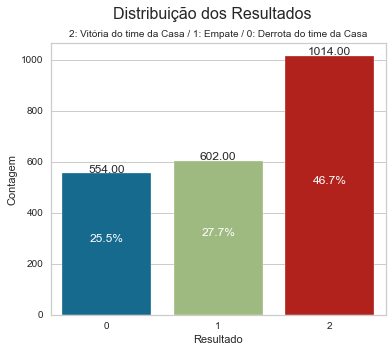

In [ ]:
#questao das classes desbalanceadas

win_graph = matches_cmp_filt_pred_modelo.reset_index()[['fixture.id','winner']].drop_duplicates()


fig, ax = plt.subplots(figsize=(6,5))

sns.countplot(win_graph['winner'], ax = ax)

plt.suptitle('Distribuição dos Resultados', fontsize = 16)
plt.title('2: Vitória do time da Casa / 1: Empate / 0: Derrota do time da Casa', fontsize = 10)
plt.xlabel('Resultado')
plt.ylabel('Contagem')

ncount = len(win_graph)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y/2), 
            ha='center', va='bottom', color = 'white')
    
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()),  ha = 'center', va = 'center', xytext = (0, 4), textcoords = 'offset points')
    
plt.show()

In [ ]:
#avalia a distribuicao das variaveis
display(matches_cmp_filt_pred_modelo.describe().T)

#avalia a correlacao entre as variaveis
display(matches_cmp_filt_pred_modelo.corr().unstack().reset_index().rename(columns={
    0: 'corr'
}).dropna().query('corr < 1').sort_values(by='corr')
       )

,count,mean,std,min,25%,50%,75%,max
league.round,2170.0,19.000000,8.946334,4.00000,11.0,19.0,27.0,34.0
league.season,2170.0,2019.000000,2.000461,2016.00000,2017.0,2019.0,2021.0,2022.0
Ball Possession,2170.0,-0.281913,9.524903,-61.40000,-5.6,0.0,5.2,60.8
Blocked Shots,2170.0,-0.067573,1.357772,-5.40000,-1.0,0.0,0.8,4.8
Corner Kicks,2170.0,-0.135982,2.004696,-7.20000,-1.4,0.0,1.2,8.4
Fouls,2170.0,0.023019,3.443873,-20.80000,-2.0,0.0,2.0,16.6
Goalkeeper Saves,2170.0,0.080080,1.257384,-5.40000,-0.8,0.0,1.0,4.8
Offsides,2170.0,-0.020770,0.885857,-3.80000,-0.6,0.0,0.6,2.8
Passes %,2170.0,-0.174452,9.046052,-85.92973,-3.6,0.0,3.2,87.4
Passes accurate,2170.0,-2.329194,98.211962,-459.80000,-64.8,0.0,55.8,468.8


,level_0,level_1,corr
10205,teams.league.failed_to_score.total,teams.league.goals.for.total.total,-0.798308
14719,teams.league.goals.for.total.total,teams.league.failed_to_score.total,-0.798308
9822,teams.league.clean_sheet.total,teams.league.goals.against.total.total,-0.797788
12994,teams.league.goals.against.total.total,teams.league.clean_sheet.total,-0.797788
12870,teams.league.goals.against.total.home,teams.league.clean_sheet.home,-0.764147
9698,teams.league.clean_sheet.home,teams.league.goals.against.total.home,-0.764147
11281,teams.league.fixtures.wins.total,teams.league.fixtures.loses.total,-0.746687
10915,teams.league.fixtures.loses.total,teams.league.fixtures.wins.total,-0.746687
9957,teams.league.failed_to_score.away,teams.league.goals.for.total.away,-0.746280
14471,teams.league.goals.for.total.away,teams.league.failed_to_score.away,-0.746280


### 5.5.1 Três Categorias - Classificar em Vitória Casa, Derrota Casa, Empate

#### 5.5.1.1 Seleção de Features

In [ ]:
#SEPARACAO EM FEATURES E TARGET

X = matches_cmp_filt_pred_modelo
y = matches_cmp_filt_pred_modelo.reset_index()['winner']

In [ ]:
def correlated_columns(df, threshold=0.85):
    return (
        df.corr()
        .pipe(
            lambda df1: pd.DataFrame(
                np.tril(df1, k=-1),
                columns=df.columns,
                index=df.columns,
            )
        )
    .stack()
    .rename("pearson")
    .pipe(
        lambda s: s[
            s.abs() > threshold
        ].reset_index()
    )
        .query("level_0 not in level_1")
    )

cr =correlated_columns(X)

X = X.drop(columns = cr['level_0'])

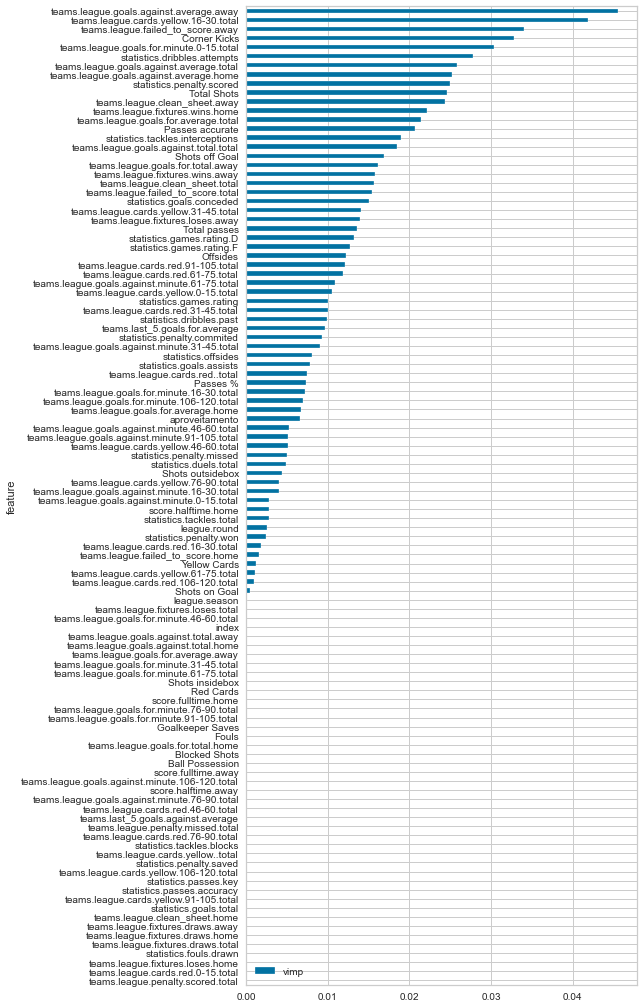

50

In [ ]:
mic = feature_selection.mutual_info_classif(X, y, random_state = 42)

fig, ax = plt.subplots(figsize=(7, 18))

features = pd.DataFrame({
    'feature': X.columns,
    "vimp": mic
})

features.set_index('feature').sort_values(by = 'vimp').plot.barh(ax = ax)

plt.show()

mask = features.set_index('feature').apply(lambda x: x>0.005).reset_index()

features = features[mask.vimp]

X = X[(features.set_index('feature').index)]

X.shape[1]

In [ ]:
X.tail()

,,,,,,Corner Kicks,Offsides,Passes %,Passes accurate,Shots off Goal,Total Shots,Total passes,aproveitamento,statistics.dribbles.attempts,statistics.dribbles.past,statistics.games.rating,statistics.games.rating.D,statistics.games.rating.F,statistics.goals.assists,statistics.goals.conceded,statistics.offsides,statistics.penalty.commited,statistics.penalty.missed,statistics.penalty.scored,statistics.tackles.interceptions,teams.last_5.goals.for.average,teams.league.cards.red..total,teams.league.cards.red.31-45.total,teams.league.cards.red.61-75.total,teams.league.cards.red.91-105.total,teams.league.cards.yellow.0-15.total,teams.league.cards.yellow.16-30.total,teams.league.cards.yellow.31-45.total,teams.league.cards.yellow.46-60.total,teams.league.clean_sheet.away,teams.league.clean_sheet.total,teams.league.failed_to_score.away,teams.league.failed_to_score.total,teams.league.fixtures.loses.away,teams.league.fixtures.wins.away,teams.league.fixtures.wins.home,teams.league.goals.against.average.away,teams.league.goals.against.average.home,teams.league.goals.against.average.total,teams.league.goals.against.minute.31-45.total,teams.league.goals.against.minute.46-60.total,teams.league.goals.against.minute.61-75.total,teams.league.goals.against.minute.91-105.total,teams.league.goals.against.total.total,teams.league.goals.for.average.home,teams.league.goals.for.average.total,teams.league.goals.for.minute.0-15.total,teams.league.goals.for.minute.106-120.total,teams.league.goals.for.minute.16-30.total,teams.league.goals.for.total.away
fixture.id,fixture.date,teams.home.id,teams.away.id,winner,league.id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
838323,2022-10-27T22:00:00+00:00,126,144,2,71,0.0,1.0,5.4,149.0,-0.2,-0.6,150.2,0.141414,3.2,0.2,0.036083,-0.056976,0.432000,0.6,-0.2,1.0,0.2,0.0,-0.2,-1.8,-0.2,-1.0,0.0,-1.0,1.0,-4.0,5.0,-3.0,2.0,1,4,0,-1,-5,2,1,-0.8,0.0,-0.4,-3.0,-8.0,4.0,2.0,-14,0.7,0.4,4.0,0.0,4.0,4
838327,2022-10-27T22:00:00+00:00,154,147,2,71,-1.0,0.0,-8.0,-48.2,1.0,-1.0,-34.0,0.101010,1.2,-0.8,0.198595,0.339429,0.079667,0.4,-1.6,0.0,0.2,0.0,0.0,-1.0,0.4,0.0,1.0,0.0,-2.0,-1.0,-3.0,-11.0,4.0,5,6,-7,-3,-6,7,-5,-1.1,-0.1,-0.6,-3.0,2.0,-6.0,1.0,-20,-0.4,0.0,2.0,0.0,1.0,9
838321,2022-10-27T22:30:00+00:00,1062,152,2,71,5.4,0.4,-1.2,59.0,-1.2,-1.4,76.0,0.272727,-2.8,2.0,0.096964,0.351143,0.045667,-0.6,-1.8,0.4,0.2,0.0,0.4,-4.2,-0.2,0.0,-2.0,-1.0,-1.0,2.0,-8.0,5.0,1.0,6,9,-2,-2,-7,5,4,-1.3,-0.4,-0.8,1.0,-8.0,-8.0,0.0,-27,0.4,0.4,2.0,0.0,1.0,7
838329,2022-10-27T23:00:00+00:00,1193,145,2,71,-1.0,0.0,-7.4,-72.0,0.4,3.4,-64.0,0.030303,-1.6,-0.8,0.054107,0.014095,0.165333,0.2,-0.6,0.0,0.0,0.0,0.0,-1.8,0.4,0.0,0.0,1.0,-1.0,0.0,-4.0,6.0,-3.0,0,2,-2,1,-1,2,-2,-0.5,-0.6,-0.6,1.0,-10.0,-7.0,0.0,-18,-0.4,0.0,0.0,0.0,-1.0,5
838308,2022-10-29T23:30:00+00:00,151,131,1,71,-1.0,0.4,-8.2,-194.4,2.2,1.2,-200.6,-0.147059,-2.0,-2.8,-0.001801,-0.026167,0.053667,-0.4,0.8,0.6,0.2,0.0,0.0,2.2,0.0,0.0,-1.0,-1.0,0.0,7.0,5.0,0.0,4.0,0,-6,1,0,1,0,-6,0.1,0.5,0.3,0.0,7.0,-5.0,2.0,11,-0.2,-0.1,-2.0,0.0,-6.0,2


#### 5.5.1.2 Divisão e Padronização

In [ ]:
# 1. Dividir os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state= 42, shuffle = False)

# 2. Padronizar as características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### 5.5.1.3 Treinamento e Parametrização

,Model Name,Test Accuracy Mean,Train Accuracy Mean,Test Std,Time
2,SVC,0.487558,0.650691,0.015256,0.306012
0,LogisticRegression,0.469124,0.542396,0.017824,0.060600
4,RandomForestClassifier,0.469124,1.000000,0.018294,0.279399
6,LGBMClassifier,0.447005,1.000000,0.037438,0.401999
5,XGBClassifier,0.435945,1.000000,0.034436,0.839398
3,DecisionTreeClassifier,0.400922,1.000000,0.023316,0.017199
7,AdaBoostClassifier,0.400000,1.000000,0.025806,0.015999
1,KNeighborsClassifier,0.393548,0.609908,0.043092,0.001000
8,GaussianNB,0.286636,0.312673,0.043367,0.001800


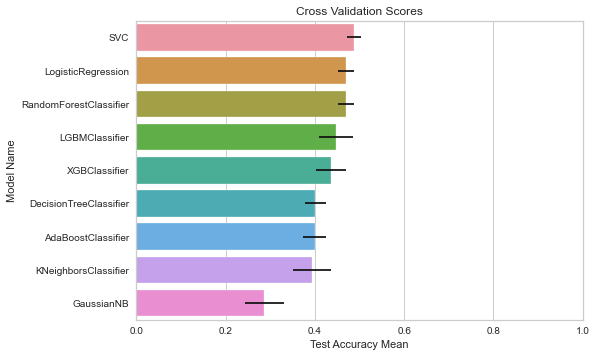

In [ ]:
# Step 1: create a map containing all estimators with their default parameters
clf_list = [
    LogisticRegression(random_state = 1),
    KNeighborsClassifier(), 
    SVC(random_state = 1, probability = True),
    DecisionTreeClassifier(random_state = 1), 
    RandomForestClassifier(random_state = 1),
    XGBClassifier(random_state = 1, use_label_encoder=False),
    LGBMClassifier(),
    AdaBoostClassifier(base_estimator = DecisionTreeClassifier(random_state = 1), random_state = 1),
    GaussianNB()]

model_check(X=X_train_scaled, y= y_train, estimators= clf_list,cv=5)

In [ ]:
base_estimators = [(est.__class__.__name__, est) for est in clf_list]

for voting in ['soft', 'hard']:
    
    voting_classifier = VotingClassifier(
        estimators = base_estimators ,
        voting = voting)
    
    cv_results = cross_validate(
        voting_classifier,
        X_train_scaled,
        y_train,
        cv = 5,
        scoring='accuracy',
        return_train_score=True,
        n_jobs=-1)
    
    print(f'\n\n\n\nResult for {voting} VotingClassifier_______\n')
    display(pd.DataFrame(cv_results).mean())





Result for soft VotingClassifier_______



fit_time       1.769521
score_time     0.048553
test_score     0.445161
train_score    1.000000
dtype: float64





Result for hard VotingClassifier_______



fit_time       1.721589
score_time     0.053144
test_score     0.458065
train_score    1.000000
dtype: float64

In [ ]:
model_param = [
    (LogisticRegression(), {'max_iter' : [100],
                            'penalty' : ['l1', 'l2'],
                            'C' : np.logspace(-2, 2, 20),
                            'solver' : ['lbfgs', 'liblinear']}),
    (KNeighborsClassifier(), {'n_neighbors' : np.arange(3, 30, 1),
                              'weights': ['uniform', 'distance'],
                              'algorithm': ['auto'],
                              'p': [1, 2]}),
    (SVC(), [{'kernel': ['rbf'], 
              'gamma': [0.001, 0.01, 0.1, 0.5, 1, 2, 5],
              'C': [0.1, 0.5,  1, 2, 5]},
              {'kernel': ['linear'], 
              'C': [.1, 1, 2, 10]},
              {'kernel': ['poly'], 
              'degree' : [2, 3, 4, 5], 
              'C': [.1, 1, 10]}]),
    #(DecisionTreeClassifier(random_state = 1), {'max_depth': [3, 5, 10, 20, 50],
    #                                            'criterion': ['entropy', 'gini'],
    #                                            'min_samples_split': [5, 10, 15, 30],
    #                                            'max_features': ['auto', 'sqrt', 'log2']}),
    (RandomForestClassifier(random_state = 42),{'n_estimators': [50, 150, 300, 450],
                                                'criterion': ['entropy'],
                                                'bootstrap': [True],
                                                'max_depth': [3, 5, 10],
                                                'max_features': ['auto','sqrt'],
                                                'min_samples_leaf': [2, 3],
                                                'min_samples_split': [2, 3]}),
    #(XGBClassifier(random_state = 1, use_label_encoder=False,tree_method='gpu_hist', gpu_id=0),{'n_estimators': [15, 25, 50, 100],
    #                                                                                            'colsample_bytree': [0.65, 0.75, 0.80],
    #                                                                                            #'max_depth': [None],
    #                                                                                            'reg_alpha': [1],
    #                                                                                            'reg_lambda': [1, 2, 5],
    #                                                                                            'subsample': [0.50, 0.75, 1.00],
    #                                                                                            'learning_rate': [0.01, 0.1, 0.5],
    #                                                                                            'gamma': [0.5, 1, 2, 5],
    #                                                                                            'min_child_weight': [0.01],
    #                                                                                            'sampling_method': ['uniform']}),
    (LGBMClassifier(random_state=42),{#'num_leaves': sp_randint(6, 50), 
                                      #'min_child_samples': sp_randint(100, 500), 
                                      'min_child_weight': [1e-5, 1e-1, 1, 1e1, 1e2, 1e4],
                                      #'subsample': sp_uniform(loc=0.2, scale=0.8), 
                                      #'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
                                      'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50],
                                      'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 10]}),
    (AdaBoostClassifier(base_estimator = DecisionTreeClassifier(random_state = 1), random_state=1),{'algorithm': ['SAMME', 'SAMME.R'],
                                                                                                    'base_estimator__criterion' : ['gini', 'entropy'],
                                                                                                    'base_estimator__splitter' : ['best', 'random'],
                                                                                                    'n_estimators': [2, 5, 10, 50],
                                                                                                    'learning_rate': [0.01, 0.1, 0.2, 0.3, 1, 2]})]

,mean_test_score,mean_train_score,std_test_score,std_train_score,params,mean_fit_time
LogisticRegression,0.498618,0.518664,0.008447,0.005520,"{'C': 0.11288378916846889, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}",0.009379
LGBMClassifier,0.497696,0.510138,0.002915,0.008786,"{'min_child_weight': 100.0, 'reg_alpha': 10, 'reg_lambda': 20}",0.096732
RandomForestClassifier,0.497696,0.518894,0.006517,0.009710,"{'bootstrap': True, 'criterion': 'entropy', 'max_depth': 3, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}",0.802597
SVC,0.496774,0.538249,0.004515,0.020355,"{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}",0.081997
KNeighborsClassifier,0.484793,1.000000,0.024799,0.000000,"{'algorithm': 'auto', 'n_neighbors': 25, 'p': 2, 'weights': 'distance'}",0.001399
AdaBoostClassifier,0.400000,1.000000,0.025806,0.000000,"{'algorithm': 'SAMME', 'base_estimator__criterion': 'gini', 'base_estimator__splitter': 'best', 'learning_rate': 0.01, 'n_estimators': 2}",0.025599


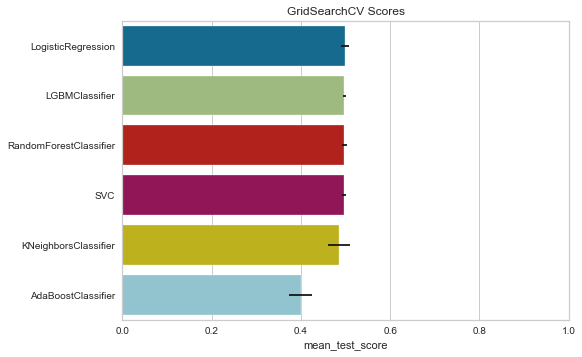

In [ ]:
tuned_models= model_tuning_check(X_train_scaled, y_train, estimators= model_param)

In [ ]:
model = VotingClassifier(
    estimators= [(clf.__class__.__name__, clf)  for clf in tuned_models],# if clf.__class__.__name__ not in ['AdaBoostClassifier', 'LogisticRegression']],
    voting='hard')

#model.fit(X_train_scaled, y_train)

result = cross_validate(model, 
               X_train_scaled,
               y_train,
               cv = 5,
               scoring='accuracy',
               return_train_score=True,
              n_jobs=-1)
print ('Tuned Voting classifier Models - \n-----------------------')
print (f'Accuracy => {np.round(result["test_score"].mean()*100, 2)} %')

Tuned Voting classifier Models - 
-----------------------
Accuracy => 50.14 %


#### 5.5.1.4 Avaliação

In [ ]:
def plot_learning_curve(estimators,
                        X,
                        y,
                        ylim=None,
                        cv=None,
                        n_jobs=None,
                        train_sizes=np.linspace(.1, 1.0, 5)):
    
    fig, axes = plt.subplots(3, 2, figsize=(25, 35))
    axes = axes.flatten()

    for ax, estimator in zip(axes, estimators):

        ax.set_title(f'{estimator.__class__.__name__} Learning Curve')
        if ylim is not None:
            ax.set_ylim(*ylim)
        ax.set_xlabel('Training examples')
        ax.set_ylabel('Score')

        train_sizes, train_scores, test_scores, fit_times, _ = \
            learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                           train_sizes=train_sizes,
                           return_times=True)
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        # Plot learning curve

        ax.fill_between(train_sizes,
                        train_scores_mean - train_scores_std,
                        train_scores_mean + train_scores_std,
                        alpha=0.1,
                        color='r')
        ax.fill_between(train_sizes,
                        test_scores_mean - test_scores_std,
                        test_scores_mean + test_scores_std,
                        alpha=0.1,
                        color='g')
        ax.plot(train_sizes,
                train_scores_mean,
                'o-',
                color='r',
                label='Training score')
        ax.plot(train_sizes,
                test_scores_mean,
                'o-',
                color='g',
                label='Cross-validation score')
        ax.legend(loc='best')
        
    plt.show()

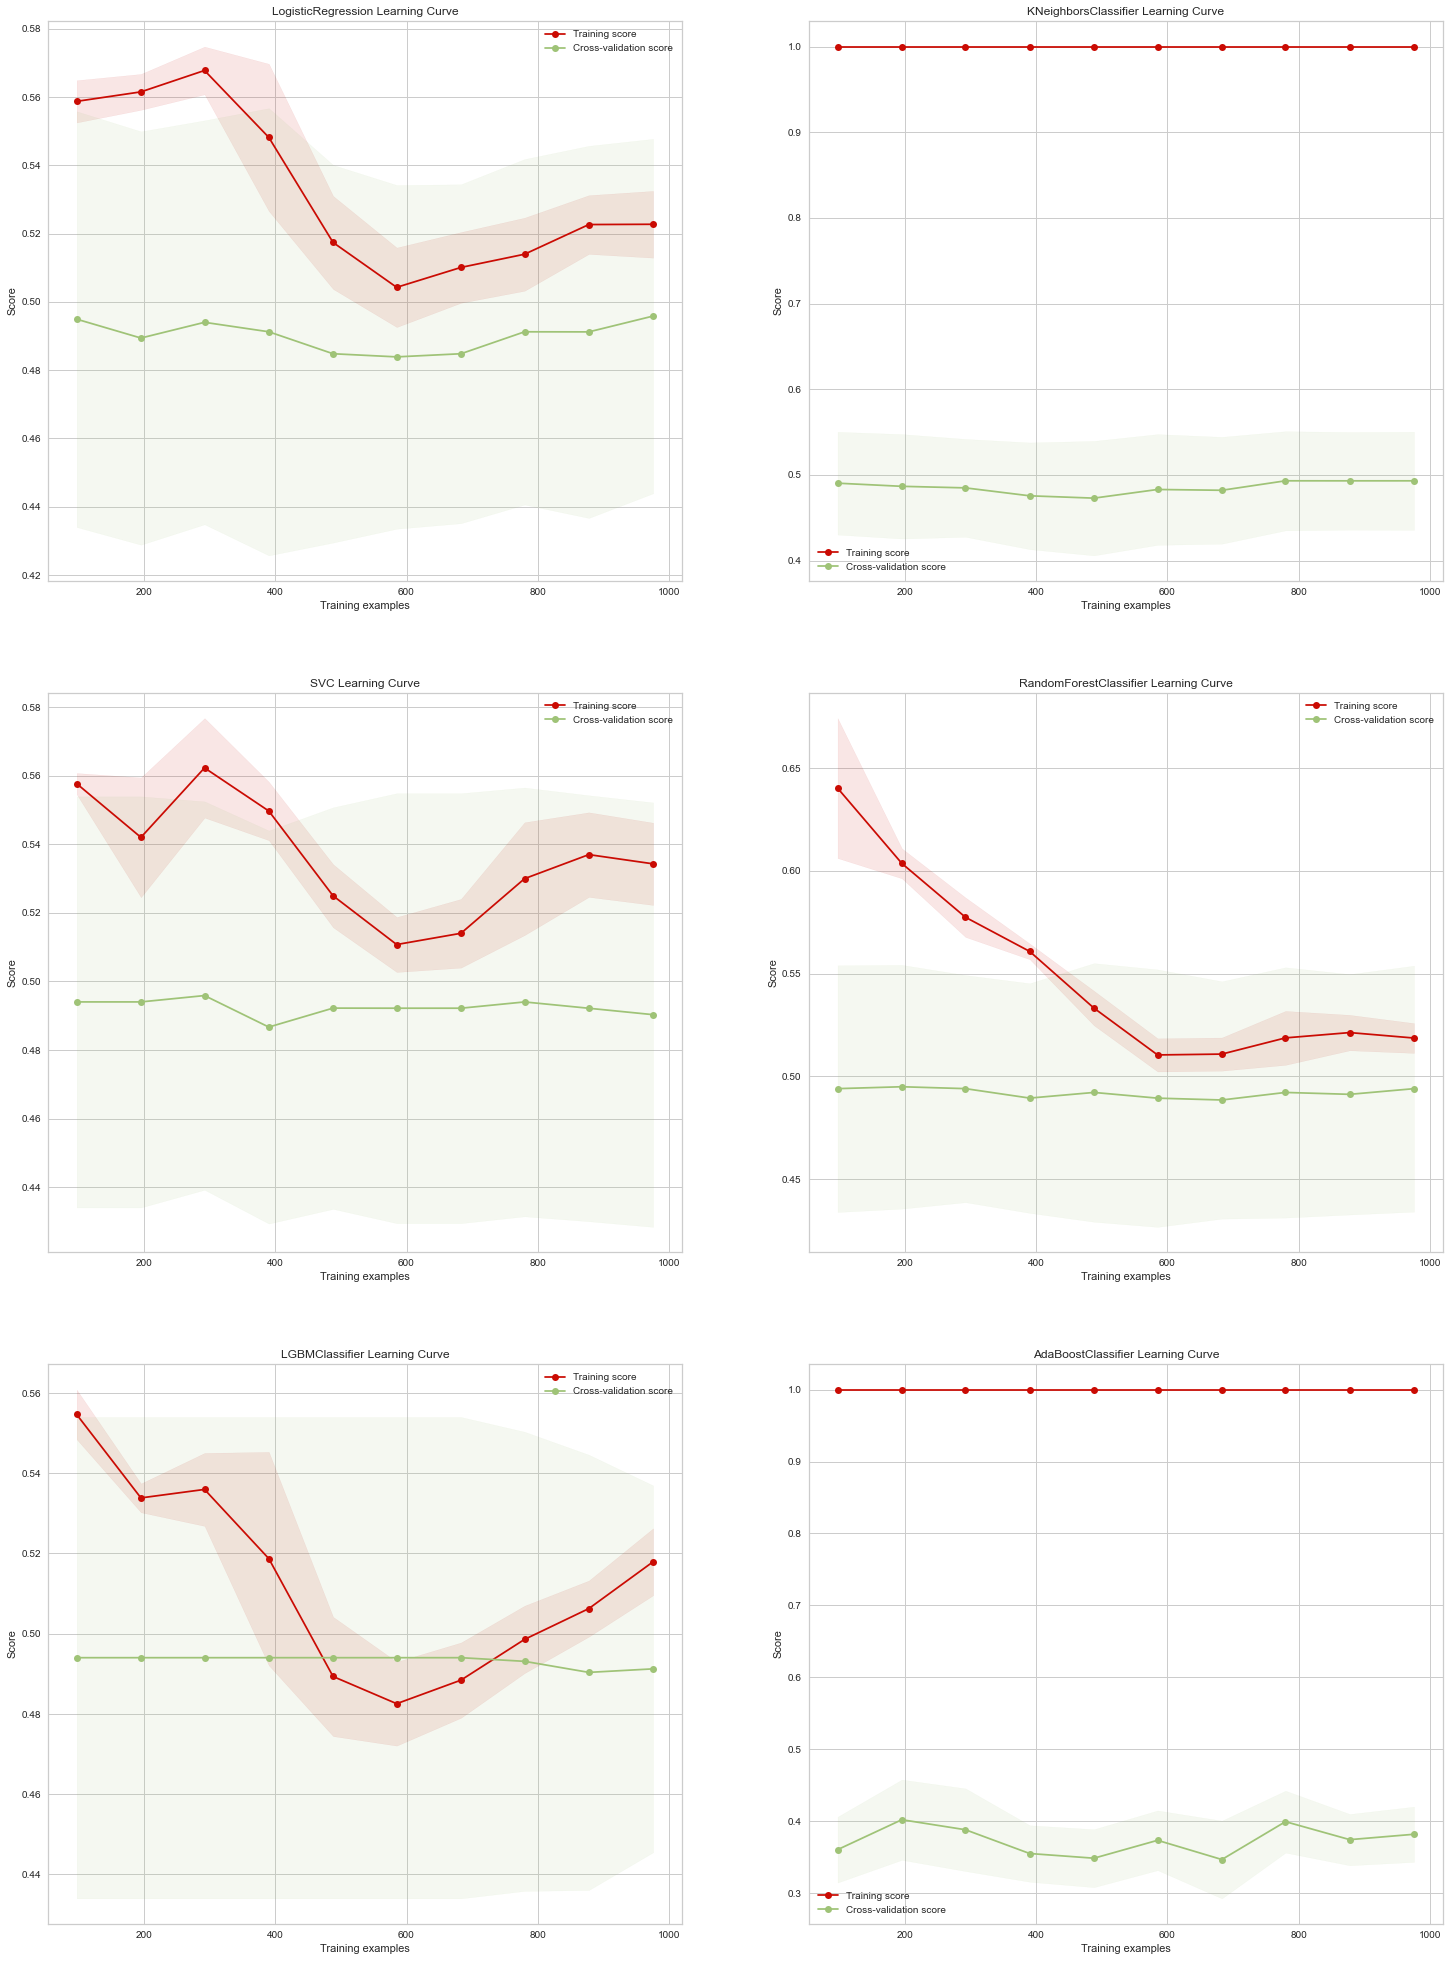

NameError: name 'all_data' is not defined

In [ ]:
plot_learning_curve(tuned_models,
                    pd.DataFrame(X_train_scaled),
                    y_train,
                    ylim=None,
                    cv=KFold(10),
                    n_jobs=-1,
                    train_sizes=np.linspace(.1, 1.0, 10))


# clean up memory
del tuned_models, model, clf_list, base_estimators, train, X_train, X_test, df

,mean_test_score,mean_train_score,std_test_score,std_train_score,params,mean_fit_time
KNeighborsClassifier,0.697696,1.000000,0.023963,0.000000,"{'algorithm': 'auto', 'n_neighbors': 3, 'p': 2, 'weights': 'distance'}",0.001200
SVC,0.674654,0.962903,0.013546,0.002765,"{'C': 2, 'gamma': 0.1, 'kernel': 'rbf'}",0.106003
RandomForestClassifier,0.623963,0.885023,0.027434,0.005616,"{'bootstrap': True, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 150}",0.407726
LGBMClassifier,0.612903,0.957373,0.038775,0.002726,"{'min_child_weight': 1e-05, 'reg_alpha': 0, 'reg_lambda': 0}",0.190626
AdaBoostClassifier,0.598157,1.000000,0.026934,0.000000,"{'algorithm': 'SAMME', 'base_estimator__criterion': 'entropy', 'base_estimator__splitter': 'best', 'learning_rate': 0.01, 'n_estimators': 2}",0.006250
LogisticRegression,0.522581,0.535945,0.048822,0.014415,"{'C': 0.01, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}",0.002401


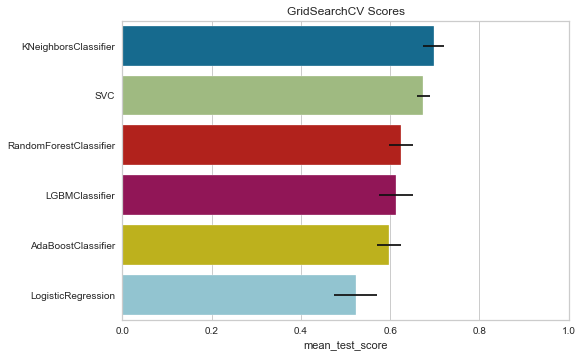

In [ ]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import NeighborhoodComponentsAnalysis

# PCA 
#X_train_pca= PCA(n_components=2).fit_transform(X_train_scaled)

# LinearDiscriminantAnalysis
#X_train_pca= LinearDiscriminantAnalysis(n_components=2).fit_transform(X_train_scaled, y_train)

# NeighborhoodComponentsAnalysis
NCA = NeighborhoodComponentsAnalysis(n_components=2).fit(X_train_scaled, y_train)

X_train_pca = NCA.transform(X_train_scaled)
X_test_pca =NCA.transform(X_test_scaled)

# memory cleanup
#del NCA, X_train_scaled, X_test_scaled

# train models on X_train_pca
models_pca= model_tuning_check(X_train_pca, y_train, estimators= model_param)

### 5.5.2 Duas Categorias - Classificar em Vitória ou Empate Casa, Derrota Casa

#### 5.5.1.1 Seleção de Features

In [ ]:
###
matches_1x = matches_cmp_filt_pred_modelo.reset_index().copy()
matches_1x['pontuou'] = np.nan
matches_1x.loc[matches_1x['winner']==2, 'pontuou']=1
matches_1x.loc[matches_1x['winner']==1, 'pontuou']=1
matches_1x.loc[matches_1x['winner']==0, 'pontuou']=0

matches_cmp_filt_pred_modelo['pontuou'] = matches_1x['pontuou'].values

In [ ]:
# Cria novos dataframes para divisão em treino e teste, sem empates
X2 = matches_cmp_filt_pred_modelo.drop(columns = 'pontuou')
y2 = matches_cmp_filt_pred_modelo['pontuou']

X2 = X2[(features.set_index('feature').index)]

# Dividir os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.4, random_state= 1333, shuffle = False)

# Padronizar as características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
#SEPARACAO EM FEATURES E TARGET
X = matches_cmp_filt_pred_modelo
y = matches_cmp_filt_pred_modelo.reset_index()['winner']

In [ ]:
def correlated_columns(df, threshold=0.85):
    return (
        df.corr()
        .pipe(
            lambda df1: pd.DataFrame(
                np.tril(df1, k=-1),
                columns=df.columns,
                index=df.columns,
            )
        )
    .stack()
    .rename("pearson")
    .pipe(
        lambda s: s[
            s.abs() > threshold
        ].reset_index()
    )
        .query("level_0 not in level_1")
    )

cr =correlated_columns(X)

X = X.drop(columns = cr['level_0'])

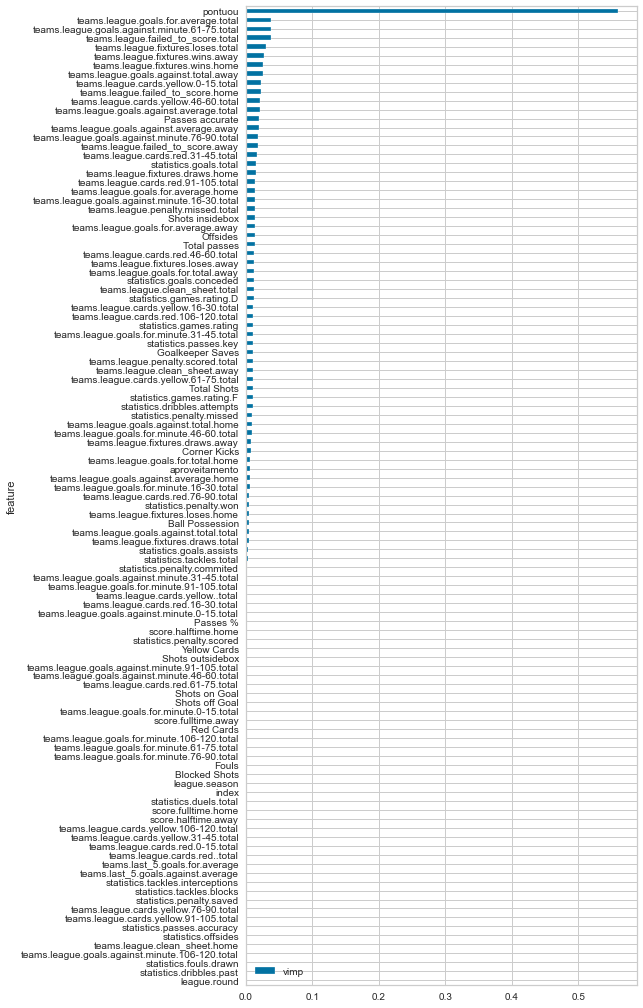

56

In [ ]:
mic = feature_selection.mutual_info_classif(X, y, random_state = 42)

fig, ax = plt.subplots(figsize=(7, 18))

features = pd.DataFrame({
    'feature': X.columns,
    "vimp": mic
})

features.set_index('feature').sort_values(by = 'vimp').plot.barh(ax = ax)

plt.show()

mask = features.set_index('feature').apply(lambda x: x>0.005).reset_index()

features = features[mask.vimp]

X = X[(features.set_index('feature').index)]

X.shape[1]

In [ ]:
X.tail()

,,,,,,Corner Kicks,Goalkeeper Saves,Offsides,Passes accurate,Shots insidebox,Total Shots,Total passes,aproveitamento,statistics.dribbles.attempts,statistics.games.rating,statistics.games.rating.D,statistics.games.rating.F,statistics.goals.conceded,statistics.goals.total,statistics.passes.key,statistics.penalty.missed,statistics.penalty.won,teams.league.cards.red.106-120.total,teams.league.cards.red.31-45.total,teams.league.cards.red.46-60.total,teams.league.cards.red.76-90.total,teams.league.cards.red.91-105.total,teams.league.cards.yellow.0-15.total,teams.league.cards.yellow.16-30.total,teams.league.cards.yellow.46-60.total,teams.league.cards.yellow.61-75.total,teams.league.clean_sheet.away,teams.league.clean_sheet.total,teams.league.failed_to_score.away,teams.league.failed_to_score.home,teams.league.failed_to_score.total,teams.league.fixtures.draws.away,teams.league.fixtures.draws.home,teams.league.fixtures.loses.away,teams.league.fixtures.loses.total,teams.league.fixtures.wins.away,teams.league.fixtures.wins.home,teams.league.goals.against.average.away,teams.league.goals.against.average.home,teams.league.goals.against.average.total,teams.league.goals.against.minute.16-30.total,teams.league.goals.against.minute.61-75.total,teams.league.goals.against.minute.76-90.total,teams.league.goals.against.total.away,teams.league.goals.against.total.home,teams.league.goals.for.average.away,teams.league.goals.for.average.home,teams.league.goals.for.average.total,teams.league.goals.for.minute.16-30.total,teams.league.goals.for.minute.31-45.total,teams.league.goals.for.minute.46-60.total,teams.league.goals.for.total.away,teams.league.goals.for.total.home,teams.league.penalty.missed.total,teams.league.penalty.scored.total,pontuou
fixture.id,fixture.date,teams.home.id,teams.away.id,winner,league.id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
838323,2022-10-27T22:00:00+00:00,126,144,2,71,0.0,-0.4,1.0,149.0,0.0,-0.6,150.2,0.141414,3.2,0.036083,-0.056976,0.432000,-0.2,-0.4,-0.6,0.0,0.0,0.0,0.0,0.0,2.0,1.0,-4.0,5.0,2.0,-1.0,1,4,0,-1,-1,4,1,-5,-8,2,1,-0.8,0.0,-0.4,-5.0,4.0,-3.0,-12,-2,0.2,0.7,0.4,4.0,4.0,1.0,4,9,0,3,1.0
838327,2022-10-27T22:00:00+00:00,154,147,2,71,-1.0,-1.2,0.0,-48.2,-0.2,-1.0,-34.0,0.101010,1.2,0.198595,0.339429,0.079667,-1.6,0.4,-1.2,0.0,0.0,0.0,1.0,0.0,-5.0,-2.0,-1.0,-3.0,4.0,3.0,5,6,-7,4,-3,0,4,-6,-6,7,-5,-1.1,-0.1,-0.6,-6.0,-6.0,-4.0,-17,-3,0.5,-0.4,0.0,1.0,2.0,-5.0,9,-8,0,-1,1.0
838321,2022-10-27T22:30:00+00:00,1062,152,2,71,5.4,-1.4,0.4,59.0,-1.0,-1.4,76.0,0.272727,-2.8,0.096964,0.351143,0.045667,-1.8,-0.2,-2.6,0.0,0.2,0.0,-2.0,-2.0,-2.0,-1.0,2.0,-8.0,1.0,-4.0,6,9,-2,0,-2,3,-3,-7,-9,5,4,-1.3,-0.4,-0.8,-8.0,-8.0,-1.0,-19,-8,0.4,0.4,0.4,1.0,1.0,8.0,7,5,0,1,1.0
838329,2022-10-27T23:00:00+00:00,1193,145,2,71,-1.0,-0.8,0.0,-72.0,3.8,3.4,-64.0,0.030303,-1.6,0.054107,0.014095,0.165333,-0.6,0.4,0.0,0.0,0.2,0.0,0.0,2.0,1.0,-1.0,0.0,-4.0,-3.0,-11.0,0,2,-2,3,1,0,3,-1,-3,2,-2,-0.5,-0.6,-0.6,0.0,-7.0,-4.0,-7,-11,0.3,-0.4,0.0,-1.0,-1.0,-5.0,5,-8,0,-8,1.0
838308,2022-10-29T23:30:00+00:00,151,131,1,71,-1.0,1.6,0.4,-194.4,0.0,1.2,-200.6,-0.147059,-2.0,-0.001801,-0.026167,0.053667,0.8,0.0,0.2,0.0,-0.2,0.0,-1.0,0.0,2.0,0.0,7.0,5.0,4.0,7.0,0,-6,1,-1,0,0,3,1,3,0,-6,0.1,0.5,0.3,1.0,-5.0,3.0,3,8,0.1,-0.2,-0.1,-6.0,-1.0,2.0,2,-4,0,3,1.0


#### 5.5.1.2 Divisão e Padronização

In [ ]:
# 1. Dividir os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state= 42, shuffle = False)

# 2. Padronizar as características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### 5.5.1.3 Treinamento e Parametrização

,Model Name,Test Accuracy Mean,Train Accuracy Mean,Test Std,Time
2,SVC,0.731797,0.805300,0.010669,0.286827
4,RandomForestClassifier,0.714286,1.000000,0.024034,0.222300
6,LGBMClassifier,0.704147,1.000000,0.035385,0.342525
0,LogisticRegression,0.701382,0.763594,0.026296,0.054570
5,XGBClassifier,0.698618,1.000000,0.025173,0.577442
8,GaussianNB,0.685714,0.718433,0.034288,0.002589
3,DecisionTreeClassifier,0.651613,1.000000,0.016894,0.015605
7,AdaBoostClassifier,0.646083,1.000000,0.011060,0.017192
1,KNeighborsClassifier,0.606452,0.742166,0.009030,0.006244


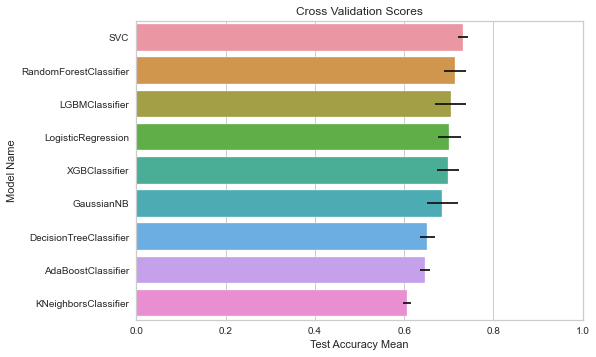

In [ ]:
# Step 1: create a map containing all estimators with their default parameters
clf_list = [
    LogisticRegression(random_state = 1),
    KNeighborsClassifier(), 
    SVC(random_state = 1, probability = True),
    DecisionTreeClassifier(random_state = 1), 
    RandomForestClassifier(random_state = 1),
    XGBClassifier(random_state = 1, use_label_encoder=False),
    LGBMClassifier(),
    AdaBoostClassifier(base_estimator = DecisionTreeClassifier(random_state = 1), random_state = 1),
    GaussianNB()]

model_check(X=X_train_scaled, y= y_train, estimators= clf_list,cv=5)

In [ ]:
base_estimators = [(est.__class__.__name__, est) for est in clf_list]

for voting in ['soft', 'hard']:
    
    voting_classifier = VotingClassifier(
        estimators = base_estimators ,
        voting = voting)
    
    cv_results = cross_validate(
        voting_classifier,
        X_train_scaled,
        y_train,
        cv = 5,
        scoring='accuracy',
        return_train_score=True,
        n_jobs=-1)
    
    print(f'\n\n\n\nResult for {voting} VotingClassifier_______\n')
    display(pd.DataFrame(cv_results).mean())





Result for soft VotingClassifier_______



fit_time       1.513238
score_time     0.045463
test_score     0.705991
train_score    1.000000
dtype: float64





Result for hard VotingClassifier_______



fit_time       1.505580
score_time     0.045614
test_score     0.720737
train_score    1.000000
dtype: float64

In [ ]:
model_param = [
    (LogisticRegression(), {'max_iter' : [100],
                            'penalty' : ['l1', 'l2'],
                            'C' : np.logspace(-2, 2, 20),
                            'solver' : ['lbfgs', 'liblinear']}),
    (KNeighborsClassifier(), {'n_neighbors' : np.arange(3, 30, 1),
                              'weights': ['uniform', 'distance'],
                              'algorithm': ['auto'],
                              'p': [1, 2]}),
    (SVC(), [{'kernel': ['rbf'], 
              'gamma': [0.001, 0.01, 0.1, 0.5, 1, 2, 5],
              'C': [0.1, 0.5,  1, 2, 5]},
              {'kernel': ['linear'], 
              'C': [.1, 1, 2, 10]},
              {'kernel': ['poly'], 
              'degree' : [2, 3, 4, 5], 
              'C': [.1, 1, 10]}]),
    #(DecisionTreeClassifier(random_state = 1), {'max_depth': [3, 5, 10, 20, 50],
    #                                            'criterion': ['entropy', 'gini'],
    #                                            'min_samples_split': [5, 10, 15, 30],
    #                                            'max_features': ['auto', 'sqrt', 'log2']}),
    (RandomForestClassifier(random_state = 42),{'n_estimators': [50, 150, 300, 450],
                                                'criterion': ['entropy'],
                                                'bootstrap': [True],
                                                'max_depth': [3, 5, 10],
                                                'max_features': ['auto','sqrt'],
                                                'min_samples_leaf': [2, 3],
                                                'min_samples_split': [2, 3]}),
    #(XGBClassifier(random_state = 1, use_label_encoder=False,tree_method='gpu_hist', gpu_id=0),{'n_estimators': [15, 25, 50, 100],
    #                                                                                            'colsample_bytree': [0.65, 0.75, 0.80],
    #                                                                                            #'max_depth': [None],
    #                                                                                            'reg_alpha': [1],
    #                                                                                            'reg_lambda': [1, 2, 5],
    #                                                                                            'subsample': [0.50, 0.75, 1.00],
    #                                                                                            'learning_rate': [0.01, 0.1, 0.5],
    #                                                                                            'gamma': [0.5, 1, 2, 5],
    #                                                                                            'min_child_weight': [0.01],
    #                                                                                            'sampling_method': ['uniform']}),
    (LGBMClassifier(random_state=42),{#'num_leaves': sp_randint(6, 50), 
                                      #'min_child_samples': sp_randint(100, 500), 
                                      'min_child_weight': [1e-5, 1e-1, 1, 1e1, 1e2, 1e4],
                                      #'subsample': sp_uniform(loc=0.2, scale=0.8), 
                                      #'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
                                      'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50],
                                      'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 10]}),
    (AdaBoostClassifier(base_estimator = DecisionTreeClassifier(random_state = 1), random_state=1),{'algorithm': ['SAMME', 'SAMME.R'],
                                                                                                    'base_estimator__criterion' : ['gini', 'entropy'],
                                                                                                    'base_estimator__splitter' : ['best', 'random'],
                                                                                                    'n_estimators': [2, 5, 10, 50],
                                                                                                    'learning_rate': [0.01, 0.1, 0.2, 0.3, 1, 2]})]

,mean_test_score,mean_train_score,std_test_score,std_train_score,params,mean_fit_time
LogisticRegression,0.736406,0.737788,0.006114,0.001563,"{'C': 0.06951927961775606, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}",0.006541
SVC,0.736406,0.736406,0.001843,0.000461,"{'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}",0.104584
LGBMClassifier,0.736406,0.736406,0.001843,0.000461,"{'min_child_weight': 1e-05, 'reg_alpha': 50, 'reg_lambda': 0}",0.087187
RandomForestClassifier,0.732719,0.955300,0.010509,0.011344,"{'bootstrap': True, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}",0.202885
AdaBoostClassifier,0.680184,1.000000,0.019023,0.000000,"{'algorithm': 'SAMME', 'base_estimator__criterion': 'entropy', 'base_estimator__splitter': 'random', 'learning_rate': 0.01, 'n_estimators': 2}",0.014982
KNeighborsClassifier,0.660829,0.699770,0.022311,0.017707,"{'algorithm': 'auto', 'n_neighbors': 16, 'p': 2, 'weights': 'uniform'}",0.000796


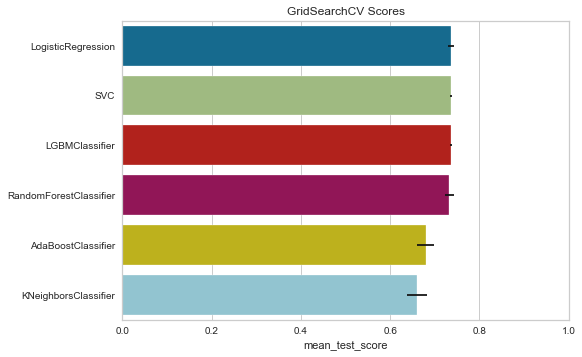

In [ ]:
tuned_models = model_tuning_check(X_train_scaled, y_train, estimators= model_param)

In [ ]:
model = VotingClassifier(
    estimators= [(clf.__class__.__name__, clf)  for clf in tuned_models],# if clf.__class__.__name__ not in ['AdaBoostClassifier', 'LogisticRegression']],
    voting='hard')

#model.fit(X_train_scaled, y_train)

result = cross_validate(model, 
               X_train_scaled,
               y_train,
               cv = 5,
               scoring='accuracy',
               return_train_score=True,
              n_jobs=-1)
print ('Tuned Voting classifier Models - \n-----------------------')
print (f'Accuracy => {np.round(result["test_score"].mean()*100, 2)} %')

Tuned Voting classifier Models - 
-----------------------
Accuracy => 73.92 %


#### 5.5.1.4 Avaliação